# Interacting with CLIP

This is a self-contained notebook that shows how to download and run CLIP models, calculate the similarity between arbitrary image and text inputs, and perform zero-shot image classifications.

# Preparation for Colab

Make sure you're running a GPU runtime; if not, select "GPU" as the hardware accelerator in Runtime > Change Runtime Type in the menu. The next cells will install the `clip` package and its dependencies, and check if PyTorch 1.7.1 or later is installed.

In [1]:
import numpy as np
import torch
from pkg_resources import packaging

print("Torch version:", torch.__version__)


Torch version: 1.11.0


# Loading the model

`clip.available_models()` will list the names of available CLIP models.

In [2]:
import clip

clip.available_models()

['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14']

In [3]:
model, preprocess = clip.load("RN50")
model.cuda().eval()
input_resolution = model.visual.input_resolution
context_length = model.context_length
vocab_size = model.vocab_size

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")
print("Input resolution:", input_resolution)
print("Context length:", context_length)
print("Vocab size:", vocab_size)

Model parameters: 102,007,137
Input resolution: 224
Context length: 77
Vocab size: 49408


# Image Preprocessing

We resize the input images and center-crop them to conform with the image resolution that the model expects. Before doing so, we will normalize the pixel intensity using the dataset mean and standard deviation.

The second return value from `clip.load()` contains a torchvision `Transform` that performs this preprocessing.



In [5]:
preprocess

Compose(
    Resize(size=224, interpolation=bicubic, max_size=None, antialias=None)
    CenterCrop(size=(224, 224))
    <function _transform.<locals>.<lambda> at 0x7f3a24ffb440>
    ToTensor()
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
)

# Text Preprocessing

We use a case-insensitive tokenizer, which can be invoked using `clip.tokenize()`. By default, the outputs are padded to become 77 tokens long, which is what the CLIP models expects.

In [6]:
clip.tokenize("Hello World!")

tensor([[49406,  3306,  1002,   256, 49407,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0]])

# Setting up input images and texts

We are going to feed 8 example images and their textual descriptions to the model, and compare the similarity between the corresponding features.

The tokenizer is case-insensitive, and we can freely give any suitable textual descriptions.

In [62]:
import os
# import skimage
import IPython.display
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import seaborn as sns
from collections import OrderedDict
import torch

%matplotlib inline
%config InlineBackend.figure_format = 'retina'


import Utils


ModuleNotFoundError: No module named 'seaborn'

In [31]:
result_file = "country100_results.csv"
gold, predicts, probs, filenames = Utils.read_resultcsv(result_file)
predict = [x[0] for x in predicts]


In [54]:
num = 155

In [55]:
file = f"F:\Mapillary\\train\\{filenames[num]}"+ ".jpg"
image = Image.open(file)
gold[num], predict[num]

('France', 'France')

In [59]:
probs[155]

[0.6173860430717468,
 0.26213669776916504,
 0.12047728896141052,
 9.514665948036844e-24,
 2.6553837069883163e-24]

In [64]:
filenames[155]

'kaBH6AWUtjfI1rKeYhyoEg'

In [60]:
# for idx, prob in enumerate(probs):
#     prob = prob[0]
#     if prob > 0.5 and prob <0.8:
#         if gold[idx] == predict[idx]:
            
#             print(idx)
    


In [56]:
yticks = [f"This is a photo of {x}, a country" for x in predicts[num]]

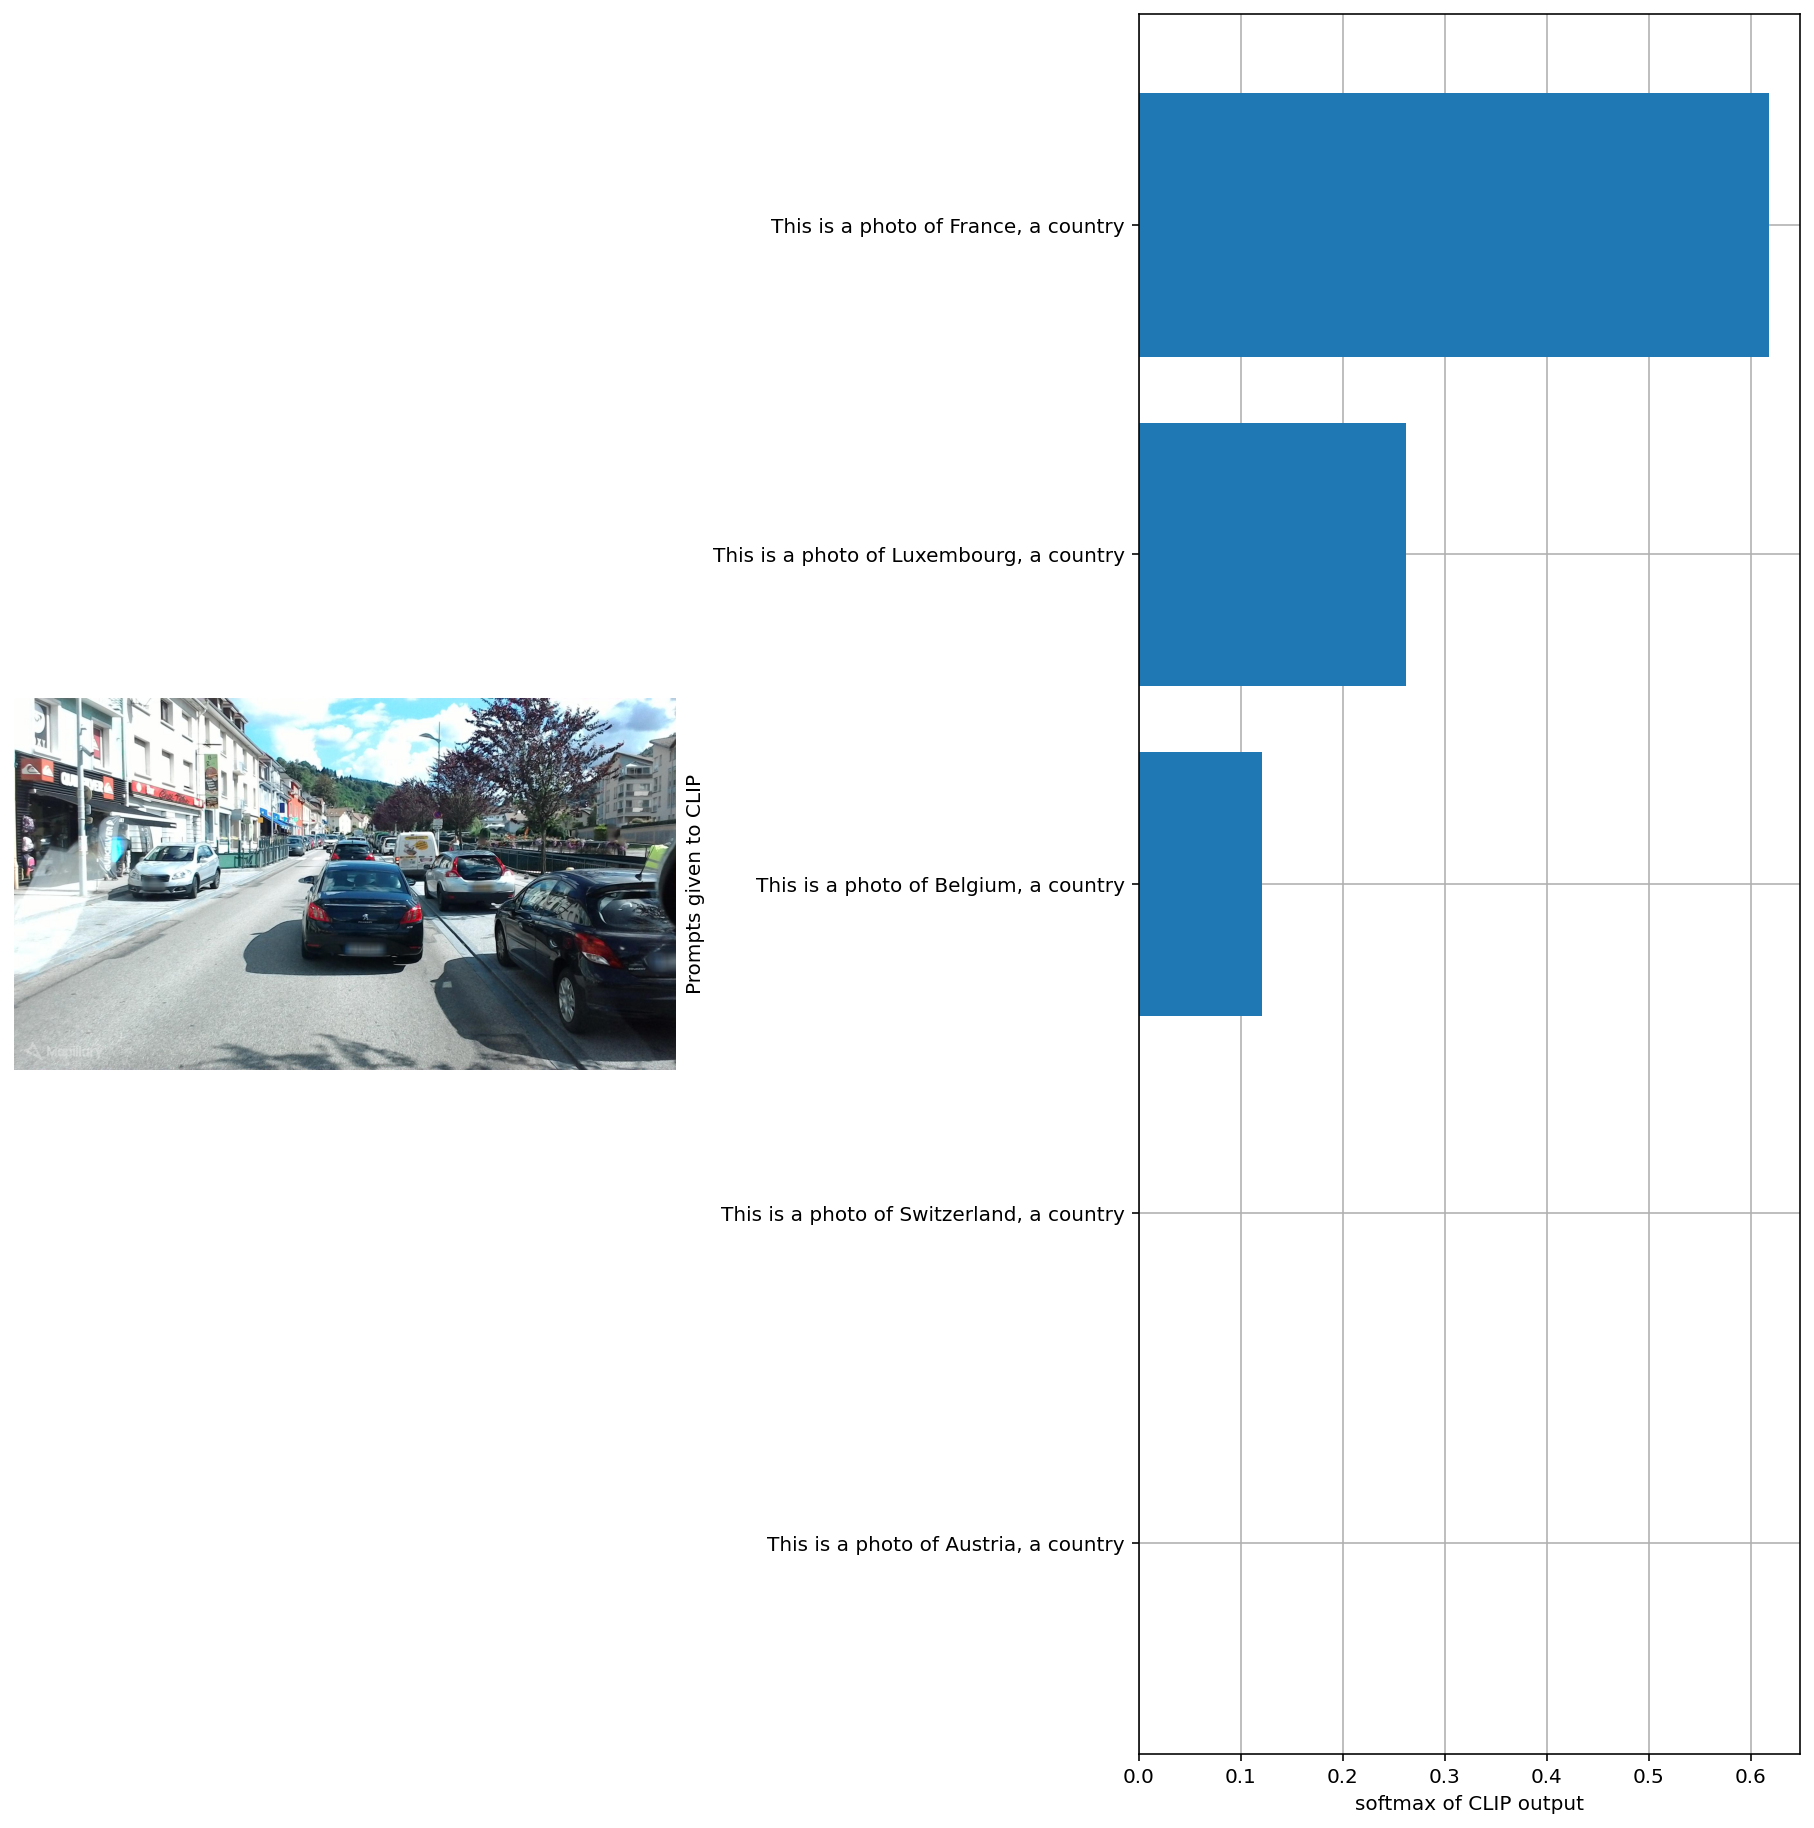

In [61]:
plt.figure(figsize=(16, 16))

plt.title("Top 5 CLIP output for an image from Belgium")
plt.subplot(1, 2,1)
plt.imshow(image)
plt.axis("off")
y = np.arange(5)
plt.subplot(1, 2, 2)
plt.grid()
plt.barh(y, probs[num])
plt.gca().invert_yaxis()
plt.gca().set_axisbelow(True)
plt.ylabel("Prompts given to CLIP")
plt.yticks(y, yticks)
plt.xlabel("softmax of CLIP output")

plt.subplots_adjust(wspace=0.7)
plt.show()